# Imports

In [1]:
# Standard library imports
import os
from datetime import datetime

# Third-party library imports
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from torch.distributions import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
from tqdm import tqdm

# Local application/library specific imports

from objectives import compute_elbo_dist as compute_elbo#, compute_elbo_mmd,compute_elbo_dreg
from test_functions_torch import calculate_fid_routine
from utils import Constants, initialize_weights, unpack_data_biked


True


In [2]:
device =  "cuda"
print(device)

cuda


In [3]:
torch.manual_seed(0)

In [4]:
project_path = '../'

In [5]:
from models.gmrf_mvae_biked import Biked_GMMVAE

# Utils

In [6]:
def plot_cond_superposition(cond, generation, n_cond, n_sample, components_names = ['crank', 'frame', 'handle', 'saddle', 'wheel']):
    """
    Plots a grid of n_images x n_cond to compare modalities of the same object.
    
    - Supports both grayscale (H, W) or (1, H, W) and color (3, H, W) images.
    
    :param cond: List (length n_cond) of condition images.
    :param generation: List of lists, where generation[j][i] has shape [1, H, W] or [3, H, W].
    :param n_cond: Number of conditions (columns).
    :param n_sample: Number of samples per condition.
    """
    n_rows =  n_sample + 1  # Condition + generated images
    n_cols = n_cond
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for j in range(n_cols):
        ax = axes[0, j]
        img = cond[j][0].detach().cpu()
        # Ensure the correct shape for displaying
        if img.ndimension() == 2:  # (H, W)
            img_np = img.numpy()
            ax.imshow(img_np, cmap="gray")  # Use grayscale colormap
        elif img.shape[0] == 1:  # (1, H, W)
            img_np = img.squeeze(0).numpy()
            ax.imshow(img_np, cmap="gray")  # Use grayscale colormap
        elif img.shape[0] == 3:  # (3, H, W) -> RGB image
            img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
            ax.imshow(img_np)

        ax.axis("off")
        ax.set_title(components_names[j])
    for k in range(n_sample):
        for j in range(n_cols):
            # print(i,j,k)
            ax = axes[k+1, j]

            img = generation[k][j][0].detach().cpu()

            # Ensure the correct shape for displaying
            if img.ndimension() == 2:  # (H, W)
                img_np = img.numpy()
                ax.imshow(img_np, cmap="gray")  # Use grayscale colormap
            elif img.shape[0] == 1:  # (1, H, W)
                img_np = img.squeeze(0).numpy()
                ax.imshow(img_np, cmap="gray")  # Use grayscale colormap
            elif img.shape[0] == 3:  # (3, H, W) -> RGB image
                img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
                ax.imshow(img_np)

            ax.axis("off")


    plt.tight_layout()
    plt.show()


In [7]:
def plot_modalities(modalities, n_images):
    """
    Plots a grid of n_images x 5 to compare modalities of the same object.
    
    :param modalities: A list of 5 batches with shape [Batch_size, 3, 28, 28].
    :param n_images: Number of images to display from each modality.
    """
    # Set up the subplot grid
    fig, axes = plt.subplots(n_images, 5, figsize=(15, 3 * n_images))
    
    for i in range(n_images):
        for j in range(5):
            ax = axes[i][j] if n_images > 1 else axes[j]
            # Extract the i-th image from the j-th modality
            img = modalities[j][i].detach().cpu().numpy().T
            ax.imshow(img)
            ax.axis('off')  # Turn off axis
            if i == 0:
                # Label the top of each column with the modality number
                ax.set_title(f'Modality {j+1}')
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_modalities(modalities, n_images):
    """
    Plots a grid of n_images x 5 to compare modalities of the same object.
    
    :param modalities: A list of 5 batches with shape [Batch_size, 3, 28, 28].
    :param n_images: Number of images to display from each modality.
    """
    # Set up the subplot grid
    fig, axes = plt.subplots(n_images, 6, figsize=(15, 3 * n_images))
    
    for i in range(n_images):
        superpose = np.zeros_like(modalities[0][0].detach().cpu().numpy()).transpose(1,2,0)
        for j in range(5):
            ax = axes[i][j] if n_images > 1 else axes[j]
            img = modalities[j][i].detach().cpu().numpy().transpose(1,2,0)
            superpose+=img
            ax.imshow(img)
            ax.axis('off')  # Turn off axis
            # if i == 0:
                # Label the top of each column with the modality number
                # ax.set_title(f'Modality {j+1}')
        ax = axes[i][5] if n_images > 1 else axes[5]
        ax.imshow(superpose)
        ax.axis('off') 
        ax.set_title(str(i))
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_cond_modalities(cond, modalities, n_images):
    """
    Plots a grid of n_images x 5 to compare modalities of the same object.
    
    :param modalities: A list of 5 batches with shape [Batch_size, 3, 28, 28].
    :param n_images: Number of images to display from each modality.
    """
    # Set up the subplot grid
    fig, axes = plt.subplots(n_images, 6, figsize=(15, 3 * n_images))
    
    for i in range(n_images):
        for j in range(6):
            ax = axes[i][j] if n_images > 1 else axes[j]
            if j==0:
                img = cond[i].detach().cpu().numpy().T
            # Extract the i-th image from the j-th modality
            else:
                img = modalities[j-1][i].detach().cpu().numpy().T
            ax.imshow(img)
            ax.axis('off')  # Turn off axis
            if i == 0:
                if j==0:
                    # Label the top of each column with the modality number
                    ax.set_title('Condition')
                else:
                # Label the top of each column with the modality number
                    ax.set_title(f'Modality {j+1}')
    
    plt.tight_layout()
    plt.show()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
def plot_training_curves(mean_losses, mean_log_px_zs, mean_kls):
    epochs = len(mean_losses)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), mean_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), mean_log_px_zs, label='log p(x|z)')
    plt.xlabel('Epochs')
    plt.ylabel('log p(x|z)')
    plt.title('log p(x|z)')

    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), mean_kls, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence')

    plt.tight_layout()
    plt.show()

In [12]:
def plot_covariance_matrix(cov_matrix, block_sizes, off_diag=False, cmap='hot', grid_color='white', grid_linewidth=2, title='Absolute Values of Covariance Matrix with Blocks'):
    """
    Plots a heatmap of a covariance matrix with gridlines delineating the blocks.
    If off_diag is True, the diagonal blocks are covered with white squares.

    Parameters:
    - cov_matrix: 2D numpy array representing the covariance matrix.
    - block_sizes: List of integers representing the size of each square block.
    - off_diag: Boolean flag to cover diagonal blocks with white squares.
    - cmap: Colormap for the heatmap.
    - grid_color: Color of the gridlines.
    - grid_linewidth: Width of the gridlines.
    """
    plt.imshow(abs(cov_matrix), cmap=cmap, interpolation='nearest')
    plt.colorbar()

    # Determine the boundaries of the blocks
    block_boundaries = np.cumsum([0] + block_sizes)

    # Plot white squares on diagonal blocks if off_diag is True
    if off_diag:
        ax = plt.gca()
        start = 0
        for size in block_sizes:
            # Create a white rectangle
            rect = patches.Rectangle((start, start), size, size, linewidth=0, edgecolor=None, facecolor='white')
            ax.add_patch(rect)
            start += size

    # Draw gridlines based on block boundaries
    for boundary in block_boundaries:
        plt.axhline(boundary - 0.5, color=grid_color, linestyle='-', linewidth=grid_linewidth)
        plt.axvline(boundary - 0.5, color=grid_color, linestyle='-', linewidth=grid_linewidth)

    # Hide the axis
    plt.axis('off')
    plt.title(title)

    # Show the plot with gridlines
    plt.show()


In [13]:
def plot(modalities, n_images):
    """
    Plots a grid of n_images x 5 to compare modalities of the same object.
    
    :param modalities: A list of 5 batches with shape [Batch_size, 3, 28, 28].
    :param n_images: Number of images to display from each modality.
    """
    # Set up the subplot grid
    fig, axes = plt.subplots(n_images, 5, figsize=(15, 3 * n_images))
    
    for i in range(n_images):
        for j in range(5):
            ax = axes[i][j] if n_images > 1 else axes[j]
            # Extract the i-th image from the j-th modality
            img = modalities[j][i].detach().cpu().numpy().transpose(1,2,0)
            ax.imshow(img)
            ax.axis('off')  # Turn off axis
            if i == 0:
                # Label the top of each column with the modality number
                ax.set_title(f'Modality {j+1}')
    
    plt.tight_layout()
    plt.show()

In [14]:
def remove_diagonal_blocks(cov_matrix, block_sizes):
    """
    Returns a new matrix with the diagonal blocks set to zero.

    Parameters:
    - cov_matrix: 2D numpy array representing the covariance matrix.
    - block_sizes: List of integers representing the size of each square block.

    Returns:
    - A new covariance matrix with diagonal blocks set to zero.
    """
    new_cov_matrix = cov_matrix.copy()
    start = 0
    for block_size in block_sizes:
        end = start + block_size
        new_cov_matrix[start:end, start:end] = np.zeros((block_size, block_size))
        start = end
    return new_cov_matrix

In [15]:
def update_learning_rate(epoch, optimizer, base_lr, max_lr, warmup_epochs):
    """Updates the learning rate over a span of epochs.
    
    Args:
        epoch: Current epoch.
        base_lr: Initial learning rate at the start of warmup.
        max_lr: Target learning rate after warmup.
        warmup_epochs: Number of epochs over which warmup occurs.
    """
    if epoch < warmup_epochs:
        lr = base_lr + (max_lr - base_lr) * (epoch / warmup_epochs)
    else:
        lr = max_lr

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train

## Train function

In [16]:
num_workers = 4
hidden_dim=128
n_layers=2
latent_dim=4
diagonal_transf = 'softplus'#'exp'#relu
reduced = False
centered = False


In [17]:
class Params():
    def __init__(self,latent_dim=latent_dim, diagonal_transf =diagonal_transf,
                 inception_module_path = '../data/pt_inception-2015-12-05-6726825d.pth'):
        self.latent_dim = latent_dim
        self.diagonal_transf = diagonal_transf
        self.tmpdir = '../data'
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device
        self.reduced_diag = reduced
        self.centered = centered
        self.inception_module_path = inception_module_path
        # self.n_layers_vae = n_layers_vae

In [18]:
# # Params SOTA
# my_lt = latent_dim
# lt = 32
# n_modalities = 5
# w_param = z_param = 2*lt
# n_params = n_modalities*(w_param+z_param)
# print('params SOTA ', n_params)

# n = n_modalities*my_lt
# print('n ', n)
# my_n_params = (1-alpha)*n*(n-1)//2+2*n
# print('my params ', my_n_params)

In [39]:
gmrf_mvae.modality_vaes[0]

GMRF_VAE_BIKED(
  (enc): Enc(
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (2): ResnetBlock(
        (conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_s): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (3): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (4): ResnetBlock(
        (conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (5): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (6): 

#### Train no loop

In [19]:
gmrf_mvae = Biked_GMMVAE(Params()).to(device)
# load_path ='../runs/gmrf/resnet/ep_50_mse_50_l1_beta_0.0001_lt_4_n_2_hd_128_tf_softplus_20250203_134432_l1/model_state_dict_49.pt'
load_path = '../runs/gmrf/resnet/best_ep_100_beta_0.0001_lt_4_n_2_hd_128_tf_softplus_20250202_201526/model_state_dict_99.pt'
load_path = '../runs/gmrf/resnet/ep_100_beta_0.0001_lt_4_n_2_hd_128_tf_softplus_20250209_221945/model_state_dict_99.pt'
gmrf_mvae.load_state_dict(torch.load(load_path),strict=False)
# gmrf_mvae.mask_off_diag()

iside latest model
off_diag_scale  0.1


<All keys matched successfully>

In [20]:
print('cov params ' ,count_parameters(gmrf_mvae.off_diag_cov))
for vae in gmrf_mvae.modality_vaes:
    print('vae params ' ,count_parameters(vae))
    print('enc params ' ,count_parameters(vae.enc))
    print('dec params ' ,count_parameters(vae.dec))
    break

cov params  39840
vae params  1565647
enc params  840300
dec params  725347


In [21]:
count_parameters(gmrf_mvae)

7868305

In [22]:
if False:
    diag_p_data = gmrf_mvae.diag_p.detach().cpu().numpy()
    off_diag_p_data = gmrf_mvae.off_diag_p.detach().cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns of subplots

    # First subplot for diag_p
    axs[0].hist(np.exp(diag_p_data), bins=30)
    axs[0].set_title(r'Exp Diag $L_p$')

    # Second subplot for off_diag_p
    axs[1].hist(off_diag_p_data, bins=30)
    axs[1].set_title(r'Off-diag $L_p$')

    plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
    plt.show()


In [23]:
batch_size = 256
train_loader, test_loader = gmrf_mvae.getDataLoaders(batch_size = batch_size, num_workers = num_workers, pin_memory = False)

In [24]:
n=10
generation = gmrf_mvae.generate(n)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

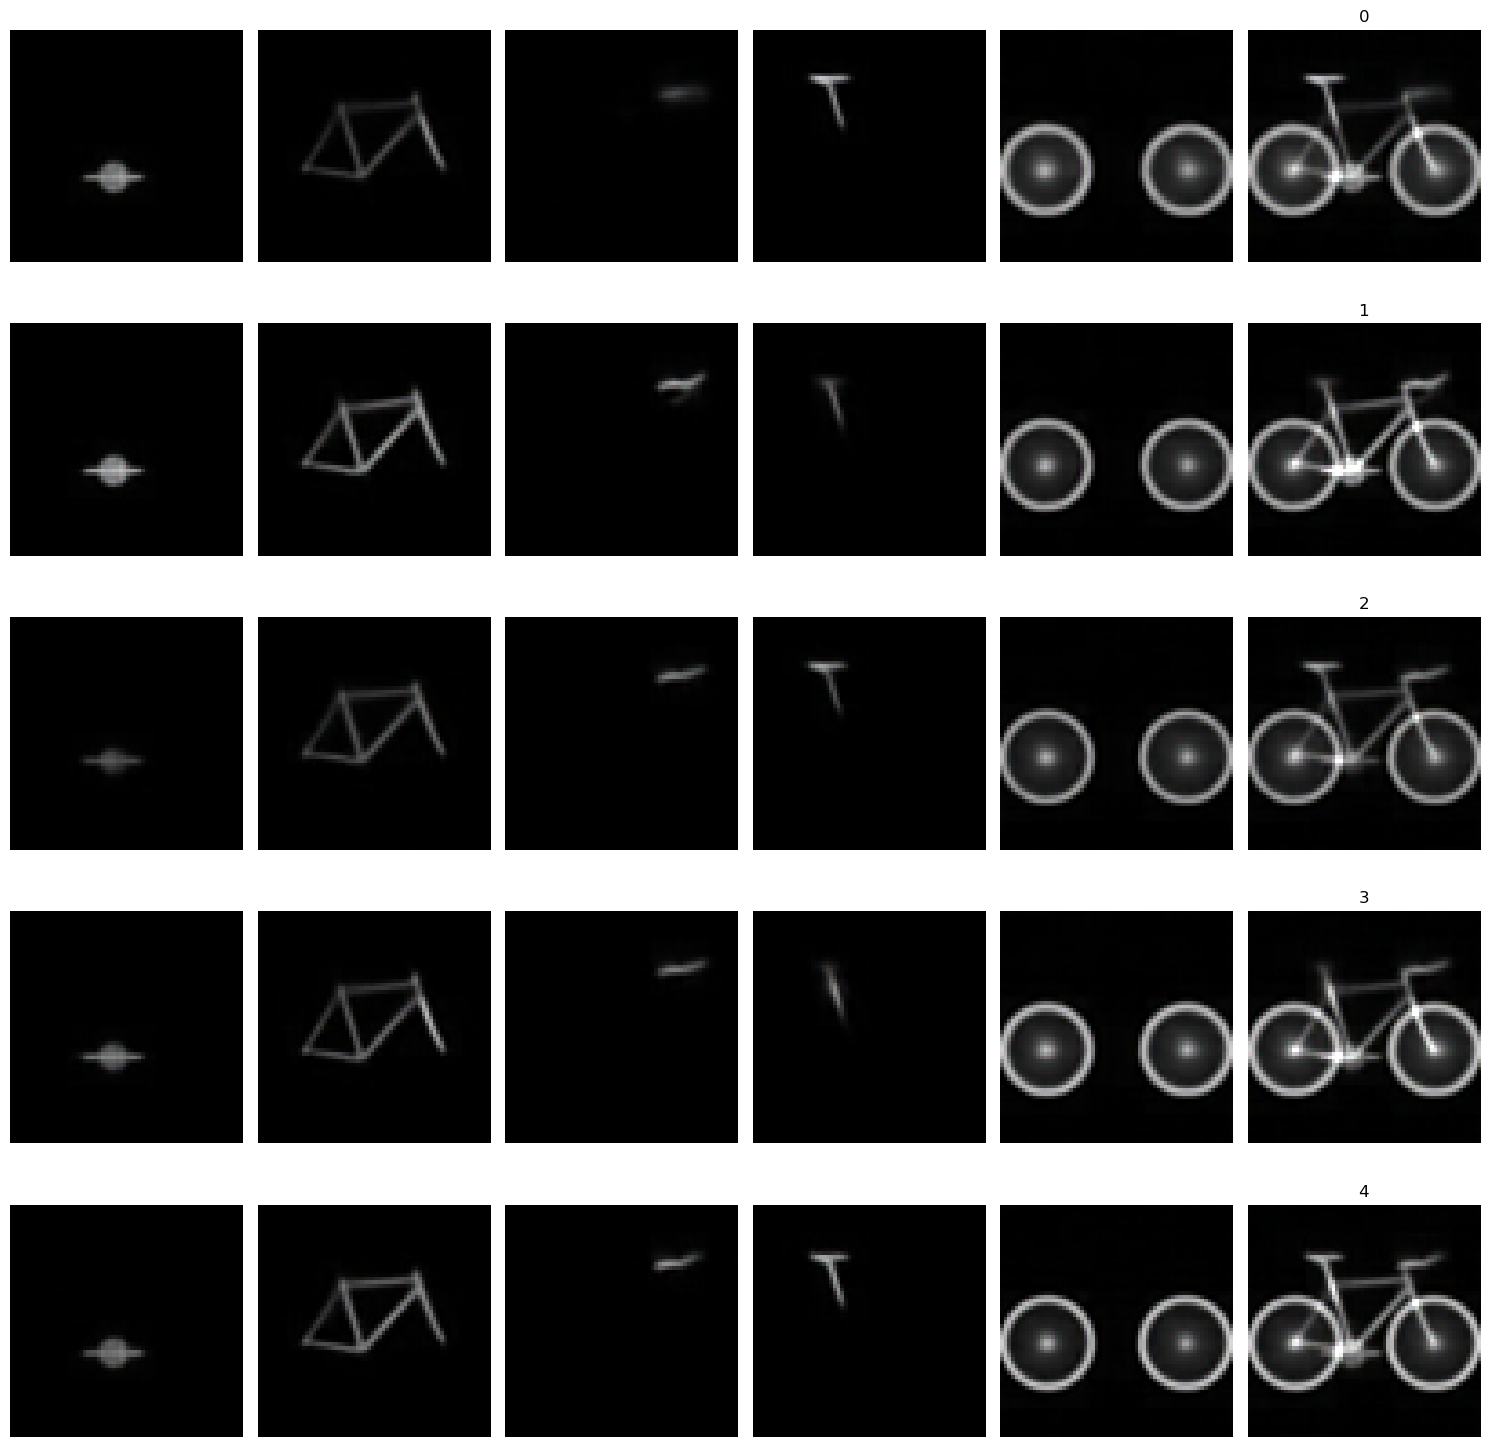

In [25]:
plot_modalities(generation, n_images=5)

In [ ]:
len(generation), generation[0].shape

In [26]:
data,_ = next(iter(test_loader))
data = [d.to(device) for d in data]
gmrf_mvae(data)

Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device


In [27]:
latent_dims = [latent_dim for _ in range(5)]

In [28]:
latent_dims

[4, 4, 4, 4, 4]

In [29]:
gmrf_mvae.qz_x.scale_tril.shape

torch.Size([256, 20, 20])

In [159]:
reconstructions = gmrf_mvae.recons
# reconstructions = [r.detach().cpu().numpy() for r in reconstructions]
# plot(reconstructions, 5)

In [33]:
if False:
    n=10
    data, _ = next(iter(test_loader))
    for j in range(5):
        cond = data[j][:n].to(device) 
        cond_gens = []
        for i in range(5):
            cond_gens.append(gmrf_mvae.conditional_generate(cond, i,j , n_sample=1))
        to_plot = [data]+ cond_gens
        plot_cond_modalities(cond, cond_gens, n)

In [34]:
def plot_cond_paper(cond, generation, n_cond, n_sample, n_modalities = 5):
    """
    Plots a grid of n_images x 5 to compare modalities of the same object.
    
    :param modalities: A list of 5 batches with shape [Batch_size, 3, 28, 28].
    :param n_images: Number of images to display from each modality.
    """
    n_rows =  n_modalities*n_sample+1
    n_cols = n_cond
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i][j] #if n_images > 1 else axes[j]
            if i==0:
                img = cond[j][0].detach().cpu().numpy().transpose(1, 2, 0)           
            else:
                img = generation[j][i-1][0].detach().cpu().numpy().transpose(1, 2, 0)
                
            ax.imshow(img)
            ax.axis('off')  # Turn off axis
            if i == 0:
                # Label the top of each column with the modality number
                ax.set_title(f'Modality {j+1}')
    
    plt.tight_layout()
    plt.show()

In [35]:
def plot_conditional_generations(data_cpu, model, num_sample=4, n_modalities = 5, n_cond=5, resolution = 64):
    device = model.device
    data = [d.to(device) for d in data_cpu]
    colors = [
        torch.tensor([0.121, 0.466, 0.70]),  # Blue
        torch.tensor([1.0, 0.498, 0.054]),  # Orange
        torch.tensor([0.172, 0.627, 0.172]),  # Green
        torch.tensor([0.839, 0.153, 0.157]),  # Red
        torch.tensor([0.580, 0.404, 0.741]),  # Purple
        torch.tensor([0.549, 0.337, 0.294]),  # Brown
    ]
    # data, labels = next(iter(test_loader))
    indexes = [np.random.randint(data[0].shape[0]) for i in range(n_cond)]
    cond = [d[i-1:i] for d,i in zip(data,indexes)]
    # print([labels[i-1].item() for i in indexes])
    cond_gens=[]
    for k in range(num_sample):
        cond_gens_k = []
        for i in range(n_cond): # condition
            superposition_i =  torch.zeros((1, 3, resolution, resolution))
            for j in range(n_modalities):
                cg_i = model.conditional_generate(cond[i], j,i , n_sample=1)
                superposition_i+= cg_i.cpu().expand(-1, 3, -1, -1) * colors[j].view(1, 3, 1, 1)
            cond_gens_k.append(superposition_i)
        cond_gens.append(cond_gens_k)
    plot_cond_superposition(cond, cond_gens, n_cond, num_sample)

In [36]:
def plot_conditional_generations(data_cpu, model, num_sample=4, n_modalities = 5, n_cond=5, resolution = 64):
    device = model.device
    data = [d.to(device) for d in data_cpu]
    colors = [
        torch.tensor([0.121, 0.466, 0.70]),  # Blue
        torch.tensor([1.0, 0.498, 0.054]),  # Orange
        torch.tensor([0.172, 0.627, 0.172]),  # Green
        torch.tensor([0.839, 0.153, 0.157]),  # Red
        torch.tensor([0.580, 0.404, 0.741]),  # Purple
        torch.tensor([0.549, 0.337, 0.294]),  # Brown
    ]
    # data, labels = next(iter(test_loader))
    indexes = [np.random.randint(data[0].shape[0]) for i in range(n_cond)]
    cond = [d[i-1:i] for d,i in zip(data,indexes)]
    # print([labels[i-1].item() for i in indexes])
    cond_gens=[]
    for k in range(num_sample):
        cond_gens_k = []
        for i in range(n_cond): # condition
            superposition_i =  torch.zeros((1, 3, resolution, resolution))
            for j in range(n_modalities):
                cg_i = model.conditional_generate(cond[i], j,i , n_sample=1)
                superposition_i+= cg_i.cpu().expand(-1, 3, -1, -1) * colors[j].view(1, 3, 1, 1)
            cond_gens_k.append(superposition_i)
        cond_gens.append(cond_gens_k)
    plot_cond_superposition(cond, cond_gens, n_cond, num_sample)

In [90]:
from collections import defaultdict
def plot_conditional_generations(data_cpu, model, num_sample=4, n_modalities = 5, n_cond=5, resolution = 64, with_color=False, idx=None, cond=None):
    device = model.device
    data = [d.to(device) for d in data_cpu]
    colors = [
        torch.tensor([0.121, 0.466, 0.70]),  # Blue
        torch.tensor([1.0, 0.498, 0.054]),  # Orange
        torch.tensor([0.172, 0.627, 0.172]),  # Green
        torch.tensor([0.839, 0.153, 0.157]),  # Red
        torch.tensor([0.580, 0.404, 0.741]),  # Purple
        torch.tensor([0.549, 0.337, 0.294]),  # Brown
    ]
    # data, labels = next(iter(test_loader))
    if cond==None:
        if idx ==None:
            idx = np.random.randint(data[0].shape[0])
        cond = [d[idx:idx+1] for d in data]
    # print([labels[i-1].item() for i in indexes])
    cond_gens=defaultdict(list)
    for k in range(num_sample):
        for i in range(n_cond): # condition
            superposition_i =  torch.zeros((1, 3, resolution, resolution))
            for j in range(n_modalities):
                if i==j:
                    cg_i = cond[i]
                else:
                    cg_i = model.conditional_generate(cond[i], j,i , n_sample=1)
                if with_color:
                    superposition_i+= cg_i.cpu().expand(-1, 3, -1, -1) * colors[j].view(1, 3, 1, 1)
                else:
                    superposition_i+= cg_i.cpu()
            cond_gens[i].append(superposition_i)
    return cond, cond_gens

In [167]:
import matplotlib.pyplot as plt
import torch

def plot_conditional_generations_colored(cond, cond_gens, num_sample=4, n_cond=5, resolution=64, 
                                         component_names = ['crank', 'frame', 'handle', 'saddle', 'wheel'], with_color=True):
    """
    Plots conditional generations with color-coded components.
    
    - First row: `cond[i]` (condition images).
    - Below: `num_sample` generated images from `cond_gens[i]`.
    - Each component uses its corresponding color.
    
    Args:
        cond (list of torch.Tensor): List of condition images (n_cond elements).
        cond_gens (dict): Dictionary where `cond_gens[i]` is a list of `num_sample` images.
        num_sample (int): Number of generated samples per condition.
        n_cond (int): Number of conditions (columns in plot).
        resolution (int): Image resolution (default 64x64).
    """
    # Define colors for each component
    colors = [
        torch.tensor([0.121, 0.466, 0.70]),  # Blue
        torch.tensor([1.0, 0.498, 0.054]),  # Orange
        torch.tensor([0.172, 0.627, 0.172]),  # Green
        torch.tensor([0.839, 0.153, 0.157]),  # Red
        torch.tensor([0.580, 0.404, 0.741]),  # Purple
    ]

    n_rows = num_sample + 1  # 1 row for cond, num_sample rows for generations
    fig, axes = plt.subplots(n_rows, n_cond, figsize=(n_cond * 2, n_rows * 2))

    for i in range(n_cond):  # Iterate over conditions
        # First row: Condition image
        ax = axes[0, i] if n_rows > 1 else axes[i]
        img = cond[i][0].detach().cpu()  # Extract first batch sample
        img = img.expand(3, -1, -1)  # Convert grayscale to 3 channels
        img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
        if with_color:
            img_np *= colors[i].view(1, 1, 3).numpy()  # Apply color
        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(component_names[i])

        # Next rows: Generated images
        for k in range(num_sample):
            ax = axes[k + 1, i] if n_rows > 1 else axes[i]
            img = cond_gens[i][k][0].detach().cpu()  # Extract the k-th generated image
            img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
            ax.imshow(img_np)
            ax.set_title(k)
            ax.axis("off")

    plt.tight_layout()
    plt.show()


In [35]:
batch_size = 10
train_loader, test_loader = gmrf_mvae.getDataLoaders(batch_size = batch_size, num_workers = num_workers, pin_memory = False)

In [36]:
data, _ = next(iter(test_loader))
# plot(data,5)
data = [d.to(device) for d in data]
gmrf_mvae(data)

Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device


In [ ]:
plot_modalities(data,10)

In [69]:
component_names = ['crank', 'frame', 'handle', 'saddle', 'wheel']

In [132]:
idx = 1

In [160]:
cond = torch.load( './conditions/condition_1.pt')

In [161]:
cond[0].shape

torch.Size([1, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


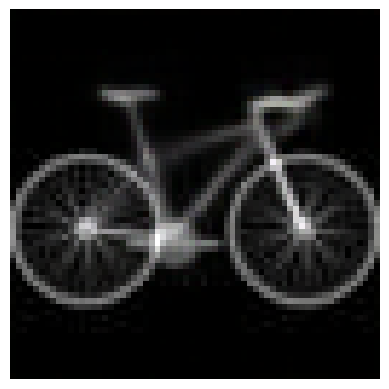

In [174]:
plt.imshow(cond_gens[4][4].squeeze(0).detach().cpu().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()

In [163]:
# cond, cond_gens = plot_conditional_generations(data, gmrf_mvae ,num_sample=40, idx = idx ,cond=[c.to('cuda') for c in cond])

In [ ]:
plot_conditional_generations_colored(cond, cond_gens, 40, with_color=False)

In [ ]:
for c in cond:
    plt.imshow(c.detach().cpu().squeeze(0).numpy().transpose(1,2,0))
    plt.axis('off')
    plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_tensors_in_column(tensor_list):
    """
    Plots a list of 5 tensors (each of shape [1, 3, 64, 64]) in a single column.

    Args:
        tensor_list (list of torch.Tensor): List of 5 tensors with shape [1, 3, 64, 64].
    """
    fig, axes = plt.subplots(len(tensor_list), 1, figsize=(3, len(tensor_list) * 3))  # Single column

    for i, tensor in enumerate(tensor_list):
        img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to NumPy (H, W, C)
        axes[i].imshow(img)
        axes[i].axis("off")  # Remove axis

    plt.tight_layout()
    plt.show()


# Plot them
plot_tensors_in_column(cond)


In [53]:
# torch.save([c.cpu() for c in cond], f'conditions/condition_{idx}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

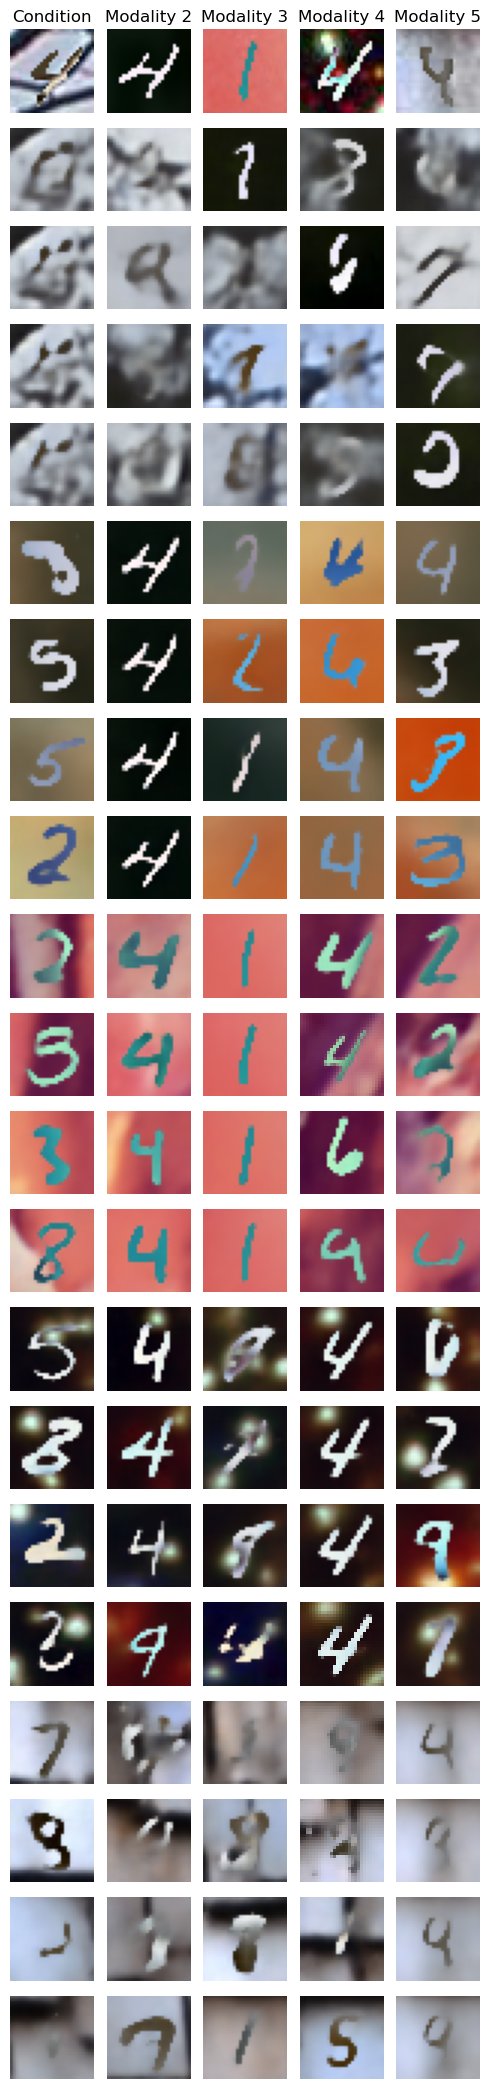

In [95]:

num_sample = 4
n_modalities = 5
n_cond=5
# data, labels = next(iter(test_loader))
indexes = [np.random.randint(data[0].shape[0]) for i in range(n_cond)]
cond = [d[i-1:i].to(device) for d,i in zip(data,indexes)]
# print([labels[i-1].item() for i in indexes])
cond_gens = []
for i in range(5):
    cond_gens_i = []
    for j in range(n_modalities):
        for k in range(num_sample):
            cond_gens_i.append(gmrf_mvae.conditional_generate(cond[i], j,i , n_sample=1))
    cond_gens.append(cond_gens_i)
# to_plot = [data]+ cond_gens
plot_cond_paper(cond, cond_gens, n_cond, num_sample, n_modalities = 5)

In [96]:
cond[0].shape

torch.Size([1, 3, 28, 28])

In [97]:
# torch.save(cond, '../data/cond.pt')

[2, 7, 9, 2, 7]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


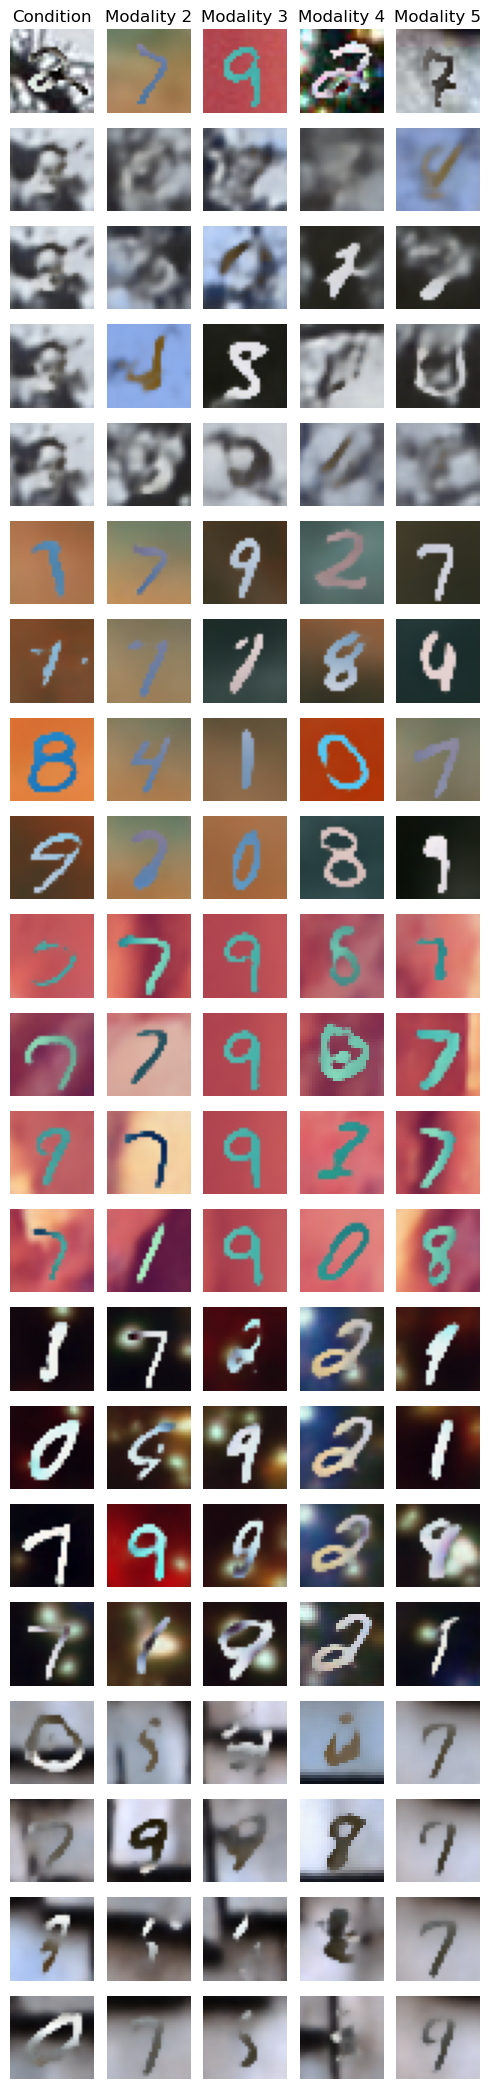

In [98]:

num_sample = 4
n_modalities = 5
n_cond=5
data, labels = next(iter(test_loader))
indexes = [np.random.randint(data[0].shape[0]) for i in range(n_cond)]
cond = [d[i-1:i].to(device) for d,i in zip(data,indexes)]
print([labels[i-1].item() for i in indexes])
cond_gens = []
for i in range(5):
    cond_gens_i = []
    for j in range(n_modalities):
        for k in range(num_sample):
            cond_gens_i.append(gmrf_mvae.conditional_generate(cond[i], j,i , n_sample=1))
    cond_gens.append(cond_gens_i)
# to_plot = [data]+ cond_gens
plot_cond_paper(cond, cond_gens, n_cond, num_sample, n_modalities = 5)

## Classifiers

### Conditional generation

In [ ]:
# n=30
# data, _ = next(iter(test_loader))
# for j in range(5):
#     cond = data[j][:n].to(device) 
#     cond_gens = []
#     for i in range(5):
#         cond_gens.append(gmrf_mvae.conditional_generate(cond, i,j , n_sample=1)) # (cond, idx_i, idx_cond, n_sample=1)
#     plot_cond_modalities(cond, cond_gens, n)

In [55]:
# test_data,conditional_labels = next(iter(test_loader))
# conditional_labels

accuracies_list = [t. item() for t in accuracies if not np.isnan(t)]
round(np.mean(accuracies_list),2)

0.87

In [62]:
np.mean(accuracies_list)

0.8688359979812328

In [ ]:
# output_dir = '/NAS/PROJECTS/BOMRGD/phd_fouad/mmvaeplus/cond_generations/'

In [56]:
np.mean(ssims)

0.9946369

In [ ]:
# get_ccoh(gmrf_mvae, test_loader, clfs, n_iter = 1)

In [25]:
# ssims = []

# for test_data,conditional_labels in tqdm(iter(test_loader)):
#     for i in range(5):
#         for j in range(5):
#             cond_gen_ij = gmrf_mvae.conditional_generate(test_data[j].to(device), i,j , n_sample=1)
#             cond_gen_ij = cond_gen_ij.cpu()
#             ssims.append(ssim(test_data[j].numpy(),cond_gen_ij.detach().cpu().numpy() , channel_axis =1, data_range = 255.))
# np.mean(ssims)       

In [73]:
batch_size = 1
train_loader, test_loader = gmrf_mvae.getDataLoaders(batch_size = batch_size, num_workers = num_workers, pin_memory = False)

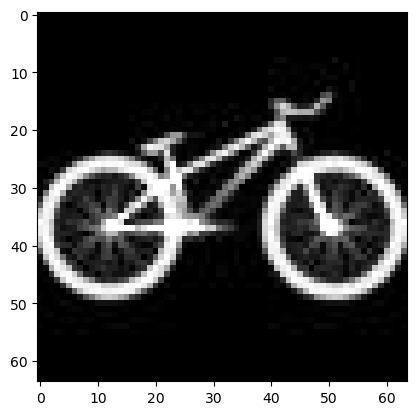

In [70]:
plt.imshow(supperposed_real.transpose(1,2,0))

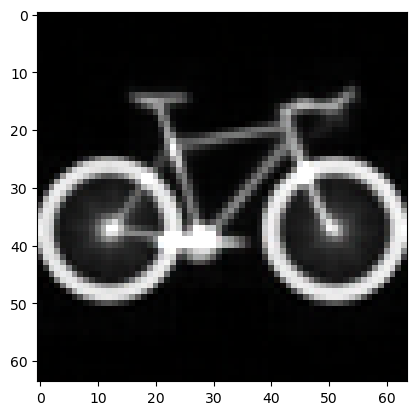

In [71]:
plt.imshow(supperposed_gen.transpose(1,2,0))

In [32]:
real_np_j.shape, gen_np.shape

((256, 3, 64, 64), (256, 3, 64, 64))

In [ ]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
use_clamp = True
ssims = []
ssims_superposed = []

for test_data, conditional_labels in tqdm(iter(test_loader)):
    # test_data is assumed to be a batch or list of tensors
    # shape might be (B, C, H, W), or similar.
    # Here we index with [j], so presumably test_data[j] is a single image with shape (C, H, W) or (H, W).

    for i in range(5):
        supperposed_real = None
        supperposed_gen = None
        real_img_i = test_data[i].detach().cpu()  # if it's on GPU
        for j in range(5):
            real_image_j = test_data[j].detach().cpu()
            # 1) Get the real image (clamp to [0,1])
            

            # 2) Generate the conditional image
            gen_img = gmrf_mvae.conditional_generate(
                real_img_i.to(device), j, i, n_sample=1
            )
            gen_img = gen_img.detach().cpu()
            
            
            if use_clamp:
                real_img_j = torch.clamp(real_image_j, 0.0, 1.0)
                gen_img = torch.clamp(gen_img, 0.0, 1.0)
            real_img_j=real_img_j.squeeze(0)
            gen_img=gen_img.squeeze(0)                             
            
            if supperposed_real==None:
                supperposed_real=torch.clone(real_img_j)
            else:
                supperposed_real+=torch.clone(real_img_j)
                
            if supperposed_gen==None:
                supperposed_gen=torch.clone(gen_img)
            else:
                supperposed_gen+=torch.clone(gen_img)
                
            # 3) Convert both to numpy
            real_np_j = real_img_j.numpy()
            gen_np  = gen_img.numpy()
            
            for k in range(real_np_j.shape[0]):
                ssim_val = ssim(real_np_j[k], gen_np[k], channel_axis=0, data_range=1.0)
                ssims.append(ssim_val)
                
            # 4) Compute SSIM in [0,1] range
            # ssim_val = ssim(real_np_j, gen_np, channel_axis=0, data_range=1.0)
            # ssims.append(ssim_val)
        
        if use_clamp:
            supperposed_real = torch.clamp(supperposed_real, 0.0, 1.0)
            supperposed_gen = torch.clamp(supperposed_gen, 0.0, 1.0)

        # 5) Convert both to numpy
        supperposed_real = supperposed_real.numpy()
        supperposed_gen  = supperposed_gen.numpy()
        
        # 6) Compute SSIM in [0,1] range
        for k in range(supperposed_real.shape[0]):
            ssim_val_sup = ssim(supperposed_real[k], supperposed_gen[k], channel_axis=0, data_range=1.0)
            ssims_superposed.append(ssim_val_sup)
        # ssim_val_sup = ssim(supperposed_real, supperposed_gen, channel_axis=0, data_range=1.0)
        # ssims_superposed.append(ssim_val_sup)
    mean_ssim = np.mean(ssims)
    mean_ssim_sup = np.mean(ssims_superposed)
    print("Mean SSIM:", mean_ssim)
    print("Mean Superposed SSIM:", mean_ssim_sup)

mean_ssim = np.mean(ssims)
mean_ssim_sup = np.mean(ssims_superposed)
print("Mean SSIM:", mean_ssim)
print("Mean Superposed SSIM:", mean_ssim_sup)

# Wasserstein key points

In [26]:
import numpy as np
from scipy.ndimage import center_of_mass

def compute_center_of_mass_2d(img3ch):
    """
    Given a 3x64x64 'grayscale' image (3 channels all the same), 
    compute the center-of-mass as an (row, col) pixel coordinate.
    """
    # 1) Average across the channel dimension => shape (64, 64)
    img_avg = img3ch.mean(axis=0)  # Now shape is (64, 64)
    
    # 2) Compute CoM from the averaged intensity. Returns floats (row, col).
    com_float = center_of_mass(img_avg)
    
    # 3) Round to nearest integer pixel
    row_int = int(round(com_float[0]))
    col_int = int(round(com_float[1]))
    
    return (row_int, col_int)


In [27]:
import numpy as np
from scipy.ndimage import center_of_mass

def compute_center_of_mass_2d(img3ch):
    """
    img3ch: (3,64,64) or (C,H,W) array.
    We average across channels => (H,W), then compute center_of_mass.
    Returns (row_int, col_int) in integer pixel coords.
    """
    if img3ch.ndim == 3:
        img_mean = img3ch.mean(axis=0)  # (H,W)
    else:
        img_mean = img3ch

    total_val = img_mean.sum()
    if total_val == 0:
        return (0, 0)

    com = center_of_mass(img_mean)
    return (int(round(com[0])), int(round(com[1])))


In [28]:
import numpy as np
from scipy.stats import wasserstein_distance

def compute_wasserstein_dist(key_points_real, key_points_generated):
    """
    key_points_real: list of (row, col) coordinates => shape (N,2)
    key_points_generated: list of (row, col) => shape (M,2)
    Returns a single float: average WD across the two dimensions.
    """
    real_arr = np.array(key_points_real)       # shape (N,2)
    gen_arr  = np.array(key_points_generated)  # shape (M,2)
    
    # Basic sanity check
    if real_arr.shape[1] != gen_arr.shape[1]:
        raise ValueError("Dimension mismatch between real and generated keypoints.")
    
    dims = real_arr.shape[1]  # Should be 2
    wd_per_dim = []
    for d in range(dims):
        # 1D Wasserstein distance along dimension d
        wd_dim = wasserstein_distance(real_arr[:, d], gen_arr[:, d])
        wd_per_dim.append(wd_dim)
    
    # Average across dimensions (row + col)
    return float(np.mean(wd_per_dim))


In [29]:
# Import necessary libraries
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim


def get_key_points(model, test_loader, device = 'cuda'):
    # SSIM lists
    key_points_real = []
    key_points_generated = []

    for test_data, conditional_labels in tqdm(iter(test_loader)):
        for k,v in test_data.items():
            test_data[k]=v.to(device)

        # Run inference
        inferred = model.inference(test_data)
        lr_subsets = inferred['subsets']
        cond_gen = model.cond_generation(lr_subsets, conditional_labels.shape[0])

        # Loop over all pairs (i, j)
        for i in range(5):
            for j in range(5):       
                cond_gen_ij = cond_gen['m{}'.format(i)]['m{}'.format(j)].cpu().detach()

                for k in range(test_data['m0'].shape[0]):
                    real_img = test_data['m{}'.format(j)][k].detach().cpu().numpy()  # Already in [0,1]
                    gen_img = torch.clamp(cond_gen_ij[k], 0, 1).numpy()  # Clipping to [0,1]
                    
                    # Compute SSIM and store
                    if i==j:
                        key_pt_real = compute_center_of_mass_2d(real_img)
                        key_points_real.append(key_pt_real)
                    key_pt_gen = compute_center_of_mass_2d(gen_img)
                    key_points_generated.append(key_pt_gen)
                    
        # Print results
    return key_points_real, key_points_generated

In [30]:
from scipy.stats import wasserstein_distance

def compute_wasserstein_distance_keypoints(real_sets, generated_sets):
    """
    real_sets: list of lists, each inner list is 5 keypoints (each keypoint is (row, col)),
               e.g. length = N, each element is length 5.
    generated_sets: list of lists, each inner list is 5 keypoints (each keypoint is (row, col)),
               e.g. length = M.
    We flatten each set to a 10-D vector and compute the average 1D Wasserstein distance
    dimension by dimension.
    """
    # Convert each set (list of 5 (row, col)) to a 10-D vector.
    real_vecs = np.array([np.array(pts).flatten() for pts in real_sets])      # shape (N, 10)
    gen_vecs = np.array([np.array(pts).flatten() for pts in generated_sets])    # shape (M, 10)
    
    dims = real_vecs.shape[1]
    wd_dims = []
    for d in range(dims):
        wd_d = wasserstein_distance(real_vecs[:, d], gen_vecs[:, d])
        wd_dims.append(wd_d)
    
    avg_wd = np.mean(wd_dims)
    return avg_wd


In [31]:
import torch
import numpy as np
from tqdm import tqdm

def get_key_points_for_gmrf_mvae(gmrf_mvae, test_loader, device='cuda', use_clamp=True):
    """
    Collects keypoints (centers of mass) for real images (only i==j)
    and for all generated images (all (i,j) pairs).
    
    Args:
        gmrf_mvae: The model with a .conditional_generate() method.
        test_loader: Iterable of (test_data, conditional_labels), 
                     where test_data is assumed to be a list/tuple of 5 images 
                     (each shape (3,H,W)) or similar.
        device: 'cuda' or 'cpu'
        use_clamp: whether to clamp images to [0,1] before computing keypoints.

    Returns:
        key_points_real: list of 2D tuples (row, col).
                         The length will be (#iterations_in_test_loader * 5).
        key_points_generated: list of 2D tuples (row, col).
                              The length will be (#iterations_in_test_loader * 25).
    """
    key_points_real = []
    key_points_generated = []
    
    gmrf_mvae.eval()
    with torch.no_grad():
        for test_data, conditional_labels in tqdm(test_loader):
            # test_data is presumably a list of length 5, each shape (3,H,W),
            # or (1,3,H,W) then .squeeze(0).
            
            # Move to device if needed. If each test_data[i] is a (3,H,W) CPU Tensor,
            # you can keep them on CPU, or move them to GPU. 
            # We'll just keep them on CPU for simplicity, as we're only computing CoMs.
            # If you do want them on GPU for generating, see below:
            
            # For i in range(5): we pick the "input" image
            for i in range(5):
                # real_img_i might be needed on GPU to pass to .conditional_generate
                real_img_i = test_data[i].to(device)  # shape (3,H,W)
                
                # We also want the center of mass for "the real image" if i == j
                # but note we do that inside the j loop for i==j.
                
                # Now for j in range(5), we do the conditional generation
                for j in range(5):
                    # ~~~~~ Real Image for j (just for the keypoint if i==j) ~~~~~
                    # Usually test_data[j] is on CPU, so let's detach it if needed:
                    real_img_j = test_data[j].detach()
                    # Optionally clamp:
                    if use_clamp:
                        real_img_j = real_img_j.clamp(0.0, 1.0)
                    
                    # If i == j, compute the real keypoint
                    if i == j:
                        real_np_j = real_img_j.cpu().numpy()  # shape (3,H,W)
                        key_pt_real_j = compute_center_of_mass_2d(real_np_j)
                        key_points_real.append(key_pt_real_j)
                    
                    # ~~~~~ Generate the conditional image ~~~~~
                    gen_img = gmrf_mvae.conditional_generate(
                        real_img_i,  # the "input" component
                        j,           # generate the j-th modality
                        i,           # conditioned on the i-th modality
                        n_sample=1
                    )
                    
                    # gen_img is on GPU, shape presumably (1,3,H,W) or (3,H,W)
                    # Let's clamp & move it to CPU:
                    gen_img = gen_img.detach().cpu()
                    if use_clamp:
                        gen_img = gen_img.clamp(0.0, 1.0)
                    
                    # If shape is (1,3,H,W), remove the batch dim:
                    if gen_img.ndim == 4 and gen_img.shape[0] == 1:
                        gen_img = gen_img.squeeze(0)  # now (3,H,W)
                    
                    gen_np = gen_img.numpy()  # shape (3,H,W)
                    
                    # Compute keypoint for generated image
                    key_pt_gen = compute_center_of_mass_2d(gen_np)
                    key_points_generated.append(key_pt_gen)
    
    return key_points_real, key_points_generated


In [32]:
from scipy.stats import wasserstein_distance
import numpy as np

def compute_wasserstein_distance_keypoints(real_sets, generated_sets):
    """
    real_sets: list of lists, each with 5 (row,col) => shape (N,5,2) after expansion
    generated_sets: shape (M,5,2).
    Flatten each 5x2 => 10D. Compute dimension-wise 1D Wasserstein, then average.
    """
    real_arr = np.array(real_sets)      # shape (N, 5, 2)
    gen_arr  = np.array(generated_sets) # shape (M, 5, 2)
    
    # Flatten => (N,10) and (M,10)
    real_arr_10d = real_arr.reshape(real_arr.shape[0], -1)  # (N,10)
    gen_arr_10d  = gen_arr.reshape(gen_arr.shape[0], -1)    # (M,10)

    dims = real_arr_10d.shape[1]  # = 10
    wd_dims = []
    for d in range(dims):
        wd_val = wasserstein_distance(real_arr_10d[:, d], gen_arr_10d[:, d])
        wd_dims.append(wd_val)
    return np.mean(wd_dims)


In [33]:
import torch
from tqdm import tqdm

def get_keypoints_unconditional_gmrf_mvae(model, train_loader, device='cuda', n_gen=1000, use_clamp=True):
    """
    Gathers center-of-mass keypoints for:
      - Real data from train_loader, which yields a list of 5 tensors:
         [m0_batch, m1_batch, ..., m4_batch],
        each of shape (batch_size, 3, 64, 64).
      - Unconditional generation from model.generate_for_calculating_unconditional_coherence(n),
        which returns a list of 5 tensors:
         [gen_m0, gen_m1, ..., gen_m4],
        each of shape (n, 3, 64, 64).

    Returns:
      key_points_real: a list (length = total # of real samples) of [ (row,col),..., (row,col) ] (5 items).
      key_points_generated: a list (length = n_gen) of [ (row,col),..., (row,col) ] (5 items).

    Each sample's set of 5 keypoints corresponds to the 5 modalities.
    """
    
    key_points_real = []       # Will hold [ [(r0,c0),(r1,c1),...,(r4,c4)], ... ] over real samples
    key_points_generated = []  # Will hold [ [(r0,c0),(r1,c1),...,(r4,c4)], ... ] over n_gen samples
    
    model.eval()
    with torch.no_grad():
        # ---- 1) Collect real data keypoints ----
        for batch_data, _ in tqdm(train_loader):
            # batch_data is presumably a list [m0_batch, m1_batch, ..., m4_batch]
            # each of shape (batch_size, 3, 64, 64).

            # Move each modality batch to device (if needed):
            for i in range(5):
                batch_data[i] = batch_data[i].to(device, non_blocking=True)
            
            batch_size = batch_data[0].shape[0]
            
            # For each sample in the batch
            for b in range(batch_size):
                # We'll gather 5 keypoints in a list => one per modality
                sample_5_real = []
                for i in range(5):
                    real_img = batch_data[i][b]  # shape (3,64,64)
                    if use_clamp:
                        real_img = real_img.clamp(0.0, 1.0)
                    
                    real_img_np = real_img.detach().cpu().numpy()  # move to CPU
                    kp = compute_center_of_mass_2d(real_img_np)
                    sample_5_real.append(kp)
                
                key_points_real.append(sample_5_real)
        
        # ---- 2) Collect unconditional generations ----
        # The method returns a list of 5 tensors: [gen_m0, gen_m1, ..., gen_m4],
        # each shape (n_gen, 3, 64, 64).
        gen_tensors = model.generate(n_gen)
        
        # Move them to CPU, clamp if needed
        for i in range(5):
            gen_tensors[i] = gen_tensors[i].detach().cpu()
            if use_clamp:
                gen_tensors[i] = torch.clamp(gen_tensors[i], 0.0, 1.0)
        
        # Now gen_tensors[i].shape = (n_gen, 3, 64, 64)
        # We'll iterate over each sample index g in range(n_gen),
        # and gather 5 keypoints for [m0..m4].
        for g in range(n_gen):
            sample_5_gen = []
            for i in range(5):
                gen_img = gen_tensors[i][g]  # shape (3,64,64)
                gen_img_np = gen_img.numpy()
                kp = compute_center_of_mass_2d(gen_img_np)
                sample_5_gen.append(kp)
            
            key_points_generated.append(sample_5_gen)
    
    return key_points_real, key_points_generated


In [34]:
key_points_real, key_points_generated =  get_keypoints_unconditional_gmrf_mvae(gmrf_mvae, train_loader, device='cuda', n_gen=1000, use_clamp=True)

100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


In [35]:
compute_wasserstein_distance_keypoints(key_points_real, key_points_generated)

0.9572666204602163

In [36]:
key_points_real, key_points_generated = get_key_points_for_gmrf_mvae(gmrf_mvae, test_loader, device='cuda', use_clamp=True)

  0%|          | 0/4 [00:00<?, ?it/s]Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MA

In [37]:
compute_wasserstein_distance_keypoints(key_points_real, key_points_generated)

0.5149999999999999

### Compute FID scores

In [19]:
batch_size = 256
train_loader, test_loader = gmrf_mvae.getDataLoaders(batch_size = batch_size, num_workers = num_workers, pin_memory = False)

In [20]:
fid_path = '../fid/ep_100_beta_0.0005/'
inception_module_path = '/NAS/USERS/e020199/BOMRGD/phd_fouad/mrf_mvae_project/data/pt_inception-2015-12-05-6726825d.pth'
datadir = '/NAS/USERS/e020199/BOMRGD/phd_fouad/mrf_mvae_project/data/PolyMNIST'

In [22]:
params = Params(inception_module_path=inception_module_path)
params.inception_module_path

'/NAS/USERS/e020199/BOMRGD/phd_fouad/mrf_mvae_project/data/pt_inception-2015-12-05-6726825d.pth'

In [23]:
# gmrf_mvae.to('cuda')

In [ ]:
mean_fid_randm, mean_fid_condgen, mean_fid_randm_superpos, mean_fid_condgen_superpos = calculate_fid_routine(gmrf_mvae, test_loader, params, datadir, fid_path, num_fid_samples= 1000, device='cuda')

In [ ]:
# ##create folders to save the outputs
# for j in [0, 1, 2, 3, 4]:
#         if os.path.exists(os.path.join(fid_path, 'random', 'm{}'.format(j))):
#             shutil.rmtree(os.path.join(fid_path, 'random', 'm{}'.format(j)))
#             os.makedirs(os.path.join(fid_path, 'random', 'm{}'.format(j)))
#         else:
#             os.makedirs(os.path.join(fid_path, 'random', 'm{}'.format(j)))
#         for i in [0, 1, 2, 3, 4]:
#             if os.path.exists(os.path.join(fid_path, 'm{}'.format(j), 'm{}'.format(i))):
#                 shutil.rmtree(os.path.join(fid_path, 'm{}'.format(j), 'm{}'.format(i)))
#                 os.makedirs(os.path.join(fid_path, 'm{}'.format(j), 'm{}'.format(i)))
#             else:
#                 os.makedirs(os.path.join(fid_path, 'm{}'.format(j), 'm{}'.format(i)))

In [ ]:
# for i, data in enumerate(test_loader):
#     data, _ = data
#     data = [d.to(device) for d in data]
#     print(len(data), data[0].shape)
#     gmrf_mvae.reconstruct_for_fid(data, save_dir, i)
#     break